<a href="https://colab.research.google.com/github/ZachZaleski/ECGR-4090/blob/main/Part2_RTAI_HW4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import collections

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

torch.set_printoptions(edgeitems=2)
torch.manual_seed(123)

In [2]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']

In [3]:
from torchvision import datasets, transforms
cifar10 = datasets.CIFAR10(
    'data', train=True, download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4915, 0.4823, 0.4468),
                             (0.2470, 0.2435, 0.2616))
    ]))


Extracting data/cifar-10-python.tar.gz to data


In [4]:
cifar10_val = datasets.CIFAR10(
    'data', train=False, download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4915, 0.4823, 0.4468),
                             (0.2470, 0.2435, 0.2616))
    ]))

Files already downloaded and verified


In [5]:
label_map = {6:0, 9: 1}
class_names = ['frog', 'horse', 'ship', 'truck']
cifar2 = [(img, label_map[label])
          for img, label in cifar10 
          if label in [6, 9]]
cifar2_val = [(img, label_map[label])
              for img, label in cifar10_val
              if label in [6, 9]]

In [7]:
connected_model = nn.Sequential(
            nn.Linear(3072, 1024),
            nn.Tanh(),
            nn.Linear(1024, 512),
            nn.Tanh(),
            nn.Linear(512, 128),
            nn.Tanh(),
            nn.Linear(128, 4))

In [8]:
numel_list = [p.numel()
              for p in connected_model.parameters()
              if p.requires_grad == True]
sum(numel_list), numel_list

(3737732, [3145728, 1024, 524288, 512, 65536, 128, 512, 4])

In [9]:
first_model = nn.Sequential(
                nn.Linear(3072, 512),
                nn.Tanh(),
                nn.Linear(512, 4),
                nn.LogSoftmax(dim=1))

In [10]:
numel_list = [p.numel() for p in first_model.parameters()]
sum(numel_list), numel_list

(1575428, [1572864, 512, 2048, 4])

In [11]:
linear = nn.Linear(3072, 1024)

linear.weight.shape, linear.bias.shape

(torch.Size([1024, 3072]), torch.Size([1024]))

In [12]:
conv = nn.Conv2d(3, 16, kernel_size=3) # <1>
conv

Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))

In [13]:
conv.weight.shape, conv.bias.shape

(torch.Size([16, 3, 3, 3]), torch.Size([16]))

In [14]:
img, _ = cifar2[0]
output = conv(img.unsqueeze(0))
img.unsqueeze(0).shape, output.shape

(torch.Size([1, 3, 32, 32]), torch.Size([1, 16, 30, 30]))

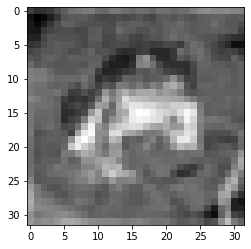

In [15]:
plt.imshow(img.mean(0), cmap='gray')
plt.show()

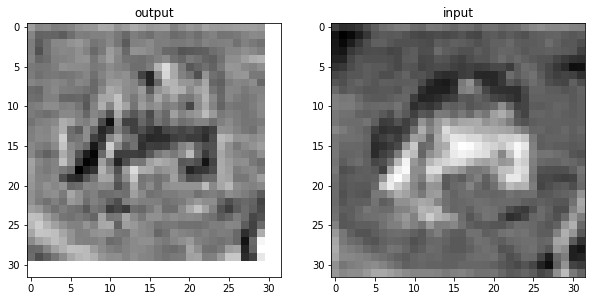

In [16]:
plt.figure(figsize=(10, 4.8))  # bookskip
ax1 = plt.subplot(1, 2, 1)   # bookskip
plt.title('output')   # bookskip
plt.imshow(output[0, 0].detach(), cmap='gray')
plt.subplot(1, 2, 2, sharex=ax1, sharey=ax1)  # bookskip
plt.imshow(img.mean(0), cmap='gray')  # bookskip
plt.title('input')  # bookskip
plt.savefig('Ch8_F2_PyTorch.png')  # bookskip
plt.show()

In [17]:
pool = nn.MaxPool2d(2)
output = pool(img.unsqueeze(0))

img.unsqueeze(0).shape, output.shape

(torch.Size([1, 3, 32, 32]), torch.Size([1, 3, 16, 16]))

In [20]:
model = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.Tanh(),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 8, kernel_size=3, padding=1),
            nn.Tanh(),
            nn.MaxPool2d(2),
            # ... <1>
            nn.Linear(8 * 8 * 8, 32),
            nn.Tanh(),
            nn.Linear(32, 2))

In [21]:
numel_list = [p.numel() for p in model.parameters()]
sum(numel_list), numel_list

(18090, [432, 16, 1152, 8, 16384, 32, 64, 2])

In [25]:
model = Net()
model(img.unsqueeze(0))

tensor([[-0.0936, -0.2172]], grad_fn=<AddmmBackward>)

In [32]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.act1 = nn.Tanh()
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.act2 = nn.Tanh()
        self.pool2 = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(8 * 8 * 8, 32)
        self.act3 = nn.Tanh()
        self.fc2 = nn.Linear(32, 4)

    def forward(self, x):
        out = self.pool1(self.act1(self.conv1(x)))
        out = self.pool2(self.act2(self.conv2(out)))
        out = out.view(-1, 8 * 8 * 8) # <1>
        out = self.act3(self.fc1(out))
        out = self.fc2(out)
        return out

In [34]:
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(8 * 8 * 8, 32)
        self.fc2 = nn.Linear(32, 4)
        
    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
        out = out.view(-1, 8 * 8 * 8)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

In [35]:
model = Net()
model(img.unsqueeze(0))

tensor([[ 0.0345, -0.0226, -0.0214,  0.1676]], grad_fn=<AddmmBackward>)

In [36]:
import datetime  # <1>

def training_loop(n_epochs, optimizer, model, loss_fn, train_loader):
    for epoch in range(1, n_epochs + 1):  # <2>
        loss_train = 0.0
        for imgs, labels in train_loader:  # <3>
            
            outputs = model(imgs)  # <4>
            
            loss = loss_fn(outputs, labels)  # <5>

            optimizer.zero_grad()  # <6>
            
            loss.backward()  # <7>
            
            optimizer.step()  # <8>

            loss_train += loss.item()  # <9>

        if epoch == 1 or epoch % 10 == 0:
            print('{} Epoch {}, Training loss {}'.format(
                datetime.datetime.now(), epoch,
                loss_train / len(train_loader)))  # <10>

In [37]:
import time

train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64,
                                           shuffle=True)  # <1>

model = Net()  #  <2>
optimizer = optim.SGD(model.parameters(), lr=1e-2)  #  <3>
loss_fn = nn.CrossEntropyLoss()  #  <4>

t0 = time.time()
training_loop(  # <5>
    n_epochs = 200,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)

t1 = time.time()
TotalTime = t1 - t0

print("Total time: ", TotalTime)

2021-04-22 18:51:59.012502 Epoch 1, Training loss 0.6805607845449144
2021-04-22 18:52:30.449921 Epoch 10, Training loss 0.18008382986210714
2021-04-22 18:53:05.501241 Epoch 20, Training loss 0.10359452213427633
2021-04-22 18:53:41.098354 Epoch 30, Training loss 0.08199557551675161
2021-04-22 18:54:17.055029 Epoch 40, Training loss 0.0641125098380978
2021-04-22 18:54:53.032934 Epoch 50, Training loss 0.05243752727130796
2021-04-22 18:55:28.345673 Epoch 60, Training loss 0.043885450384573664
2021-04-22 18:56:03.725204 Epoch 70, Training loss 0.039116279735188386
2021-04-22 18:56:39.716369 Epoch 80, Training loss 0.0355433415025354
2021-04-22 18:57:15.390528 Epoch 90, Training loss 0.029965546667267372
2021-04-22 18:57:51.459906 Epoch 100, Training loss 0.025273373659706087
2021-04-22 18:58:27.795387 Epoch 110, Training loss 0.023512028181438993
2021-04-22 18:59:04.003777 Epoch 120, Training loss 0.0203695129445579
2021-04-22 18:59:40.116770 Epoch 130, Training loss 0.018800701234922716
2

In [38]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64,
                                           shuffle=False)
val_loader = torch.utils.data.DataLoader(cifar2_val, batch_size=64,
                                         shuffle=False)

def validate(model, train_loader, val_loader):
    for name, loader in [("train", train_loader), ("val", val_loader)]:
        correct = 0
        total = 0

        with torch.no_grad():  # <1>
            for imgs, labels in loader:
                outputs = model(imgs)
                _, predicted = torch.max(outputs, dim=1) # <2>
                total += labels.shape[0]  # <3>
                correct += int((predicted == labels).sum())  # <4>

        print("Accuracy {}: {:.2f}".format(name , correct / total))

validate(model, train_loader, val_loader)

Accuracy train: 1.00
Accuracy val: 0.97


In [39]:
label_map = {0:0, 9: 1}
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
cifar2 = [(img, label_map[label])
          for img, label in cifar10 
          if label in [0, 9]]
cifar2_val = [(img, label_map[label])
              for img, label in cifar10_val
              if label in [0, 9]]

In [40]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.act1 = nn.Tanh()
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.act2 = nn.Tanh()
        self.pool2 = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(8 * 8 * 8, 32)
        self.act3 = nn.Tanh()
        self.fc2 = nn.Linear(32, 10)

    def forward(self, x):
        out = self.pool1(self.act1(self.conv1(x)))
        out = self.pool2(self.act2(self.conv2(out)))
        out = out.view(-1, 8 * 8 * 8) # <1>
        out = self.act3(self.fc1(out))
        out = self.fc2(out)
        return out

In [41]:
import datetime  # <1>

def training_loop(n_epochs, optimizer, model, loss_fn, train_loader):
    for epoch in range(1, n_epochs + 1):  # <2>
        loss_train = 0.0
        for imgs, labels in train_loader:  # <3>
            
            outputs = model(imgs)  # <4>
            
            loss = loss_fn(outputs, labels)  # <5>

            optimizer.zero_grad()  # <6>
            
            loss.backward()  # <7>
            
            optimizer.step()  # <8>

            loss_train += loss.item()  # <9>

        if epoch == 1 or epoch % 10 == 0:
            print('{} Epoch {}, Training loss {}'.format(
                datetime.datetime.now(), epoch,
                loss_train / len(train_loader)))  # <10>

In [42]:
import time

train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64,
                                           shuffle=True)  # <1>

model = Net()  #  <2>
optimizer = optim.SGD(model.parameters(), lr=1e-2)  #  <3>
loss_fn = nn.CrossEntropyLoss()  #  <4>

t0 = time.time()
training_loop(  # <5>
    n_epochs = 200,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)

t1 = time.time()
TotalTime = t1 - t0

print("Total time: ", TotalTime)

2021-04-22 19:22:04.225385 Epoch 1, Training loss 1.0794972701437155
2021-04-22 19:22:35.305791 Epoch 10, Training loss 0.30671254815948995
2021-04-22 19:23:09.693237 Epoch 20, Training loss 0.2555988774557782
2021-04-22 19:23:44.437694 Epoch 30, Training loss 0.21618632203454424
2021-04-22 19:24:19.382964 Epoch 40, Training loss 0.18654086170302833
2021-04-22 19:24:54.615039 Epoch 50, Training loss 0.16590397479902408
2021-04-22 19:25:30.161683 Epoch 60, Training loss 0.14608068413035885
2021-04-22 19:26:05.686952 Epoch 70, Training loss 0.13004349815143143
2021-04-22 19:26:41.269292 Epoch 80, Training loss 0.1186321694285247
2021-04-22 19:27:16.410052 Epoch 90, Training loss 0.1069300596714969
2021-04-22 19:27:51.420302 Epoch 100, Training loss 0.09502365983500602
2021-04-22 19:28:26.403278 Epoch 110, Training loss 0.08377674071319924
2021-04-22 19:29:01.658292 Epoch 120, Training loss 0.07786407057124718
2021-04-22 19:29:36.839322 Epoch 130, Training loss 0.06917290473772082
2021-04

In [43]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64,
                                           shuffle=False)
val_loader = torch.utils.data.DataLoader(cifar2_val, batch_size=64,
                                         shuffle=False)

def validate(model, train_loader, val_loader):
    for name, loader in [("train", train_loader), ("val", val_loader)]:
        correct = 0
        total = 0

        with torch.no_grad():  # <1>
            for imgs, labels in loader:
                outputs = model(imgs)
                _, predicted = torch.max(outputs, dim=1) # <2>
                total += labels.shape[0]  # <3>
                correct += int((predicted == labels).sum())  # <4>

        print("Accuracy {}: {:.2f}".format(name , correct / total))

validate(model, train_loader, val_loader)

Accuracy train: 1.00
Accuracy val: 0.92


In [44]:
class NetDepth(nn.Module):
    def __init__(self, n_chans1=32):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(n_chans1, n_chans1 // 2, kernel_size=3,
                               padding=1)
        self.conv3 = nn.Conv2d(n_chans1 // 2, n_chans1 // 2,
                               kernel_size=3, padding=1)
        self.fc1 = nn.Linear(4 * 4 * n_chans1 // 2, 32)
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = F.max_pool2d(torch.relu(self.conv1(x)), 2)
        out = F.max_pool2d(torch.relu(self.conv2(out)), 2)
        out = F.max_pool2d(torch.relu(self.conv3(out)), 2)
        out = out.view(-1, 4 * 4 * self.n_chans1 // 2)
        out = torch.relu(self.fc1(out))
        out = self.fc2(out)
        return out

In [50]:
import time

model = NetDepth(n_chans1=32)
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

t0 = time.time()
training_loop(
    n_epochs = 200,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)
t1 = time.time()
TotalTime = t1 - t0

print("Total time: ", TotalTime)

2021-04-22 20:45:58.474493 Epoch 1, Training loss 0.6714465944630326
2021-04-22 20:46:56.083578 Epoch 10, Training loss 0.3108898944156185
2021-04-22 20:48:00.047325 Epoch 20, Training loss 0.23948740166653493
2021-04-22 20:49:03.636600 Epoch 30, Training loss 0.18570528772606212
2021-04-22 20:50:07.079385 Epoch 40, Training loss 0.14901672631122503
2021-04-22 20:51:10.503764 Epoch 50, Training loss 0.12370870793890801
2021-04-22 20:52:14.007205 Epoch 60, Training loss 0.10302109044685864
2021-04-22 20:53:17.814769 Epoch 70, Training loss 0.0844158644307476
2021-04-22 20:54:21.726045 Epoch 80, Training loss 0.06509216871278681
2021-04-22 20:55:25.618330 Epoch 90, Training loss 0.04806190237082589
2021-04-22 20:56:29.546214 Epoch 100, Training loss 0.05828313462459927
2021-04-22 20:57:34.400692 Epoch 110, Training loss 0.022530553484288087
2021-04-22 20:58:39.432241 Epoch 120, Training loss 0.013788879229865113
2021-04-22 20:59:43.844062 Epoch 130, Training loss 0.007968043142137752
202

In [51]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64,
                                           shuffle=False)
val_loader = torch.utils.data.DataLoader(cifar2_val, batch_size=64,
                                         shuffle=False)

def validate(model, train_loader, val_loader):
    for name, loader in [("train", train_loader), ("val", val_loader)]:
        correct = 0
        total = 0

        with torch.no_grad():  # <1>
            for imgs, labels in loader:
                outputs = model(imgs)
                _, predicted = torch.max(outputs, dim=1) # <2>
                total += labels.shape[0]  # <3>
                correct += int((predicted == labels).sum())  # <4>

        print("Accuracy {}: {:.2f}".format(name , correct / total))

validate(model, train_loader, val_loader)

Accuracy train: 1.00
Accuracy val: 0.93
